# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Tue Jun  3 22:49:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P3             21W /   80W |     574MiB /   6144MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import VGG19Generator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/vgg19_model_bce",
    checkpoints_dir="../checkpoints/vgg19_model_bce",
    batch_size=2,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="vgg19",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: vgg19
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 2
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    loss_type='BCE'
)

Epoha 1/150: 100%|██████████| 229/229 [01:36<00:00,  2.36it/s, D_A=0.3452, D_B=0.0707, G=8.2026] 


Epoha 1/150 - Train gubici: G: 13.4995, D_A: 0.2355, D_B: 0.2060 | Val gubici: G: 8.3324, Cycle: 3.2808
Novi najbolji validacijski cycle gubitak: 3.2808, spremam modele...
Novi najbolji validacijski GAN gubitak: 8.3324, spremam modele...


Epoha 2/150: 100%|██████████| 229/229 [01:33<00:00,  2.45it/s, D_A=0.0806, D_B=0.0163, G=9.7758] 


Epoha 2/150 - Train gubici: G: 8.9929, D_A: 0.1682, D_B: 0.1487 | Val gubici: G: 10.1359, Cycle: 2.2625
Novi najbolji validacijski cycle gubitak: 2.2625, spremam modele...


Epoha 3/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.2365, D_B=0.0665, G=7.9312] 


Epoha 3/150 - Train gubici: G: 8.5554, D_A: 0.2424, D_B: 0.1247 | Val gubici: G: 7.2952, Cycle: 2.1451
Novi najbolji validacijski cycle gubitak: 2.1451, spremam modele...
Novi najbolji validacijski GAN gubitak: 7.2952, spremam modele...


Epoha 4/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.4516, D_B=0.1931, G=4.7928] 


Epoha 4/150 - Train gubici: G: 7.3240, D_A: 0.3018, D_B: 0.2207 | Val gubici: G: 4.2468, Cycle: 1.7914
Novi najbolji validacijski cycle gubitak: 1.7914, spremam modele...
Novi najbolji validacijski GAN gubitak: 4.2468, spremam modele...


Epoha 5/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.3668, D_B=0.1254, G=6.0538] 


Epoha 5/150 - Train gubici: G: 7.2254, D_A: 0.3116, D_B: 0.1690 | Val gubici: G: 9.8701, Cycle: 2.1736


Epoha 6/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0621, D_B=0.0635, G=8.6245] 


Epoha 6/150 - Train gubici: G: 7.9309, D_A: 0.2304, D_B: 0.1587 | Val gubici: G: 6.3474, Cycle: 1.9918


Epoha 7/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0298, D_B=0.0888, G=11.2925]


Epoha 7/150 - Train gubici: G: 8.5618, D_A: 0.1191, D_B: 0.1622 | Val gubici: G: 10.8968, Cycle: 2.3107


Epoha 8/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0955, D_B=0.1517, G=7.3534] 


Epoha 8/150 - Train gubici: G: 8.6732, D_A: 0.1704, D_B: 0.1965 | Val gubici: G: 5.4965, Cycle: 1.8326


Epoha 9/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0902, D_B=0.0564, G=7.6511] 


Epoha 9/150 - Train gubici: G: 7.6587, D_A: 0.1907, D_B: 0.1734 | Val gubici: G: 4.6880, Cycle: 1.9291


Epoha 10/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0760, D_B=0.2042, G=8.7824] 


Epoha 10/150 - Train gubici: G: 8.4158, D_A: 0.1196, D_B: 0.2016 | Val gubici: G: 6.3409, Cycle: 1.7531
Novi najbolji validacijski cycle gubitak: 1.7531, spremam modele...


Epoha 11/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1261, D_B=0.0287, G=7.8692] 


Epoha 11/150 - Train gubici: G: 8.2781, D_A: 0.1725, D_B: 0.1995 | Val gubici: G: 5.4402, Cycle: 1.7121
Novi najbolji validacijski cycle gubitak: 1.7121, spremam modele...


Epoha 12/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0530, D_B=0.0430, G=7.2456] 


Epoha 12/150 - Train gubici: G: 7.9385, D_A: 0.1441, D_B: 0.1846 | Val gubici: G: 5.6810, Cycle: 1.6991
Novi najbolji validacijski cycle gubitak: 1.6991, spremam modele...


Epoha 13/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.4934, D_B=0.1984, G=5.1265] 


Epoha 13/150 - Train gubici: G: 7.8008, D_A: 0.2005, D_B: 0.2090 | Val gubici: G: 9.1392, Cycle: 1.7224


Epoha 14/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.0552, D_B=0.0802, G=7.4805] 


Epoha 14/150 - Train gubici: G: 7.4850, D_A: 0.1879, D_B: 0.1992 | Val gubici: G: 6.2727, Cycle: 1.6554
Novi najbolji validacijski cycle gubitak: 1.6554, spremam modele...


Epoha 15/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0449, D_B=0.0693, G=6.3207] 


Epoha 15/150 - Train gubici: G: 7.5664, D_A: 0.1643, D_B: 0.2497 | Val gubici: G: 6.7263, Cycle: 1.6139
Novi najbolji validacijski cycle gubitak: 1.6139, spremam modele...


Epoha 16/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.3725, D_B=0.2433, G=5.4198] 


Epoha 16/150 - Train gubici: G: 7.4023, D_A: 0.2265, D_B: 0.2645 | Val gubici: G: 8.9335, Cycle: 1.6126
Novi najbolji validacijski cycle gubitak: 1.6126, spremam modele...


Epoha 17/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1284, D_B=0.1547, G=5.9254] 


Epoha 17/150 - Train gubici: G: 7.1333, D_A: 0.1953, D_B: 0.2397 | Val gubici: G: 8.2490, Cycle: 1.4853
Novi najbolji validacijski cycle gubitak: 1.4853, spremam modele...


Epoha 18/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.2053, D_B=0.1377, G=6.6333] 


Epoha 18/150 - Train gubici: G: 7.0933, D_A: 0.2376, D_B: 0.2561 | Val gubici: G: 5.6915, Cycle: 1.7746


Epoha 19/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.5758, D_B=0.2430, G=4.6931] 


Epoha 19/150 - Train gubici: G: 6.9011, D_A: 0.2282, D_B: 0.2353 | Val gubici: G: 7.8250, Cycle: 1.6594


Epoha 20/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1139, D_B=0.2743, G=6.3368] 


Epoha 20/150 - Train gubici: G: 7.4796, D_A: 0.2449, D_B: 0.2685 | Val gubici: G: 7.3531, Cycle: 1.8604


Epoha 21/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2036, D_B=1.2937, G=8.0212] 


Epoha 21/150 - Train gubici: G: 6.6272, D_A: 0.2102, D_B: 0.3179 | Val gubici: G: 3.9193, Cycle: 1.1554
Novi najbolji validacijski cycle gubitak: 1.1554, spremam modele...
Novi najbolji validacijski GAN gubitak: 3.9193, spremam modele...


Epoha 22/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1670, D_B=0.2407, G=7.2375]


Epoha 22/150 - Train gubici: G: 6.2343, D_A: 0.1946, D_B: 0.3655 | Val gubici: G: 4.3298, Cycle: 1.4895


Epoha 23/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1326, D_B=0.1257, G=5.5891] 


Epoha 23/150 - Train gubici: G: 6.1983, D_A: 0.2066, D_B: 0.3713 | Val gubici: G: 5.8908, Cycle: 1.1692


Epoha 24/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2181, D_B=0.6341, G=3.8945] 


Epoha 24/150 - Train gubici: G: 6.4106, D_A: 0.1750, D_B: 0.3947 | Val gubici: G: 4.6502, Cycle: 1.2931


Epoha 25/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0414, D_B=0.1747, G=9.7659] 


Epoha 25/150 - Train gubici: G: 6.9936, D_A: 0.2060, D_B: 0.3899 | Val gubici: G: 6.8389, Cycle: 1.2704


Epoha 26/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0900, D_B=0.2658, G=9.2046]


Epoha 26/150 - Train gubici: G: 6.5812, D_A: 0.1197, D_B: 0.3926 | Val gubici: G: 8.9214, Cycle: 1.0008
Novi najbolji validacijski cycle gubitak: 1.0008, spremam modele...


Epoha 27/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0650, D_B=0.9727, G=6.6185] 


Epoha 27/150 - Train gubici: G: 6.2679, D_A: 0.1795, D_B: 0.3613 | Val gubici: G: 8.1084, Cycle: 1.2321


Epoha 28/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1641, D_B=0.4045, G=3.9330] 


Epoha 28/150 - Train gubici: G: 6.0442, D_A: 0.2152, D_B: 0.3587 | Val gubici: G: 2.9931, Cycle: 1.2772
Novi najbolji validacijski GAN gubitak: 2.9931, spremam modele...


Epoha 29/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0477, D_B=0.4411, G=6.9325]


Epoha 29/150 - Train gubici: G: 6.1009, D_A: 0.1680, D_B: 0.4573 | Val gubici: G: 5.7399, Cycle: 1.0173


Epoha 30/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0412, D_B=0.7624, G=3.8384] 


Epoha 30/150 - Train gubici: G: 6.0075, D_A: 0.2524, D_B: 0.3617 | Val gubici: G: 6.1104, Cycle: 1.1003


Epoha 31/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0087, D_B=0.4259, G=12.0338]


Epoha 31/150 - Train gubici: G: 8.0279, D_A: 0.0976, D_B: 0.3404 | Val gubici: G: 7.0013, Cycle: 2.5604


Epoha 32/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1288, D_B=0.2044, G=7.3923] 


Epoha 32/150 - Train gubici: G: 11.1326, D_A: 0.0381, D_B: 0.3246 | Val gubici: G: 7.6762, Cycle: 1.5213


Epoha 33/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1045, D_B=0.4934, G=6.0881]


Epoha 33/150 - Train gubici: G: 6.5063, D_A: 0.2186, D_B: 0.2701 | Val gubici: G: 6.8621, Cycle: 1.2141


Epoha 34/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1760, D_B=0.1208, G=4.4661] 


Epoha 34/150 - Train gubici: G: 6.4705, D_A: 0.1213, D_B: 0.3465 | Val gubici: G: 4.1794, Cycle: 1.1858


Epoha 35/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1279, D_B=0.4633, G=5.5925] 


Epoha 35/150 - Train gubici: G: 6.8971, D_A: 0.1595, D_B: 0.3220 | Val gubici: G: 6.4666, Cycle: 1.1451


Epoha 36/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2142, D_B=0.5519, G=7.8842] 


Epoha 36/150 - Train gubici: G: 6.6119, D_A: 0.1681, D_B: 0.3529 | Val gubici: G: 4.8451, Cycle: 1.3036


Epoha 37/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0238, D_B=0.1890, G=5.8526] 


Epoha 37/150 - Train gubici: G: 6.7423, D_A: 0.1363, D_B: 0.3247 | Val gubici: G: 3.9204, Cycle: 1.3794


Epoha 38/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.3886, D_B=0.0882, G=5.0248] 


Epoha 38/150 - Train gubici: G: 6.5611, D_A: 0.1908, D_B: 0.2992 | Val gubici: G: 5.1753, Cycle: 1.5471


Epoha 39/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0860, D_B=0.2761, G=5.3777] 


Epoha 39/150 - Train gubici: G: 6.5600, D_A: 0.1608, D_B: 0.3056 | Val gubici: G: 4.8779, Cycle: 1.0838


Epoha 40/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.3807, D_B=0.2652, G=3.3185] 


Epoha 40/150 - Train gubici: G: 6.7323, D_A: 0.1624, D_B: 0.3057 | Val gubici: G: 9.2861, Cycle: 1.0225


Epoha 41/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.0732, D_B=0.3160, G=6.3289] 


Epoha 41/150 - Train gubici: G: 6.4648, D_A: 0.1809, D_B: 0.3680 | Val gubici: G: 8.2764, Cycle: 1.0941


Epoha 42/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2502, D_B=0.2995, G=5.5163] 


Epoha 42/150 - Train gubici: G: 6.7582, D_A: 0.1308, D_B: 0.2828 | Val gubici: G: 8.9748, Cycle: 1.1740


Epoha 43/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0861, D_B=0.0182, G=4.2205] 


Epoha 43/150 - Train gubici: G: 8.0566, D_A: 0.1493, D_B: 0.2944 | Val gubici: G: 4.3590, Cycle: 1.0250


Epoha 44/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0201, D_B=0.1767, G=7.4194] 


Epoha 44/150 - Train gubici: G: 6.5255, D_A: 0.1952, D_B: 0.2771 | Val gubici: G: 5.6547, Cycle: 0.9417
Novi najbolji validacijski cycle gubitak: 0.9417, spremam modele...


Epoha 45/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0355, D_B=0.1431, G=6.2918] 


Epoha 45/150 - Train gubici: G: 6.7058, D_A: 0.1356, D_B: 0.2772 | Val gubici: G: 5.3295, Cycle: 1.0926


Epoha 46/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0911, D_B=0.1690, G=5.1542] 


Epoha 46/150 - Train gubici: G: 6.5274, D_A: 0.1989, D_B: 0.2595 | Val gubici: G: 6.2972, Cycle: 1.0693


Epoha 47/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=1.4012, D_B=0.0786, G=10.3381]


Epoha 47/150 - Train gubici: G: 6.8318, D_A: 0.1560, D_B: 0.2817 | Val gubici: G: 2.0714, Cycle: 1.1521
Novi najbolji validacijski GAN gubitak: 2.0714, spremam modele...


Epoha 48/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0258, D_B=0.6398, G=5.0452] 


Epoha 48/150 - Train gubici: G: 6.3750, D_A: 0.2399, D_B: 0.2848 | Val gubici: G: 6.6798, Cycle: 0.9133
Novi najbolji validacijski cycle gubitak: 0.9133, spremam modele...


Epoha 49/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0899, D_B=0.3912, G=10.2899]


Epoha 49/150 - Train gubici: G: 6.4794, D_A: 0.1598, D_B: 0.2512 | Val gubici: G: 5.3768, Cycle: 1.1143


Epoha 50/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.3862, D_B=0.1697, G=4.3968] 


Epoha 50/150 - Train gubici: G: 6.8876, D_A: 0.2701, D_B: 0.2692 | Val gubici: G: 6.4424, Cycle: 1.0427


Epoha 51/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0659, D_B=1.1462, G=12.5027]


Epoha 51/150 - Train gubici: G: 6.5030, D_A: 0.1866, D_B: 0.2566 | Val gubici: G: 13.7854, Cycle: 1.9841


Epoha 52/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.1452, D_B=0.4922, G=4.7800] 


Epoha 52/150 - Train gubici: G: 6.6560, D_A: 0.1857, D_B: 0.2657 | Val gubici: G: 4.1983, Cycle: 0.9927


Epoha 53/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2787, D_B=0.4726, G=7.9688] 


Epoha 53/150 - Train gubici: G: 6.1337, D_A: 0.2064, D_B: 0.2662 | Val gubici: G: 6.3294, Cycle: 0.9880


Epoha 54/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.0405, D_B=0.0578, G=5.4982] 


Epoha 54/150 - Train gubici: G: 6.3217, D_A: 0.2287, D_B: 0.2227 | Val gubici: G: 6.2496, Cycle: 1.1467


Epoha 55/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1605, D_B=0.1093, G=5.8225] 


Epoha 55/150 - Train gubici: G: 6.3361, D_A: 0.1955, D_B: 0.2110 | Val gubici: G: 4.1839, Cycle: 0.9808


Epoha 56/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.2016, D_B=0.0139, G=5.3364] 


Epoha 56/150 - Train gubici: G: 6.2552, D_A: 0.1959, D_B: 0.2202 | Val gubici: G: 8.2986, Cycle: 1.1295


Epoha 57/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1079, D_B=0.1984, G=5.9108] 


Epoha 57/150 - Train gubici: G: 6.3126, D_A: 0.2182, D_B: 0.2431 | Val gubici: G: 4.6126, Cycle: 1.0573


Epoha 58/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0667, D_B=0.0692, G=6.4708] 


Epoha 58/150 - Train gubici: G: 6.4234, D_A: 0.1873, D_B: 0.1952 | Val gubici: G: 4.6145, Cycle: 1.0225


Epoha 59/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0484, D_B=0.3092, G=3.8183] 


Epoha 59/150 - Train gubici: G: 6.1889, D_A: 0.2888, D_B: 0.2221 | Val gubici: G: 6.4476, Cycle: 1.0054


Epoha 60/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.5524, D_B=0.0839, G=5.3037] 


Epoha 60/150 - Train gubici: G: 6.3626, D_A: 0.1889, D_B: 0.2033 | Val gubici: G: 10.0901, Cycle: 0.9445


Epoha 61/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.4057, D_B=0.0413, G=5.3274] 


Epoha 61/150 - Train gubici: G: 6.2474, D_A: 0.2114, D_B: 0.1898 | Val gubici: G: 8.7725, Cycle: 0.9615


Epoha 62/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1216, D_B=0.3281, G=6.3072] 


Epoha 62/150 - Train gubici: G: 6.5820, D_A: 0.1980, D_B: 0.1720 | Val gubici: G: 4.6886, Cycle: 1.1077


Epoha 63/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2030, D_B=0.2259, G=6.0473] 


Epoha 63/150 - Train gubici: G: 6.4699, D_A: 0.2328, D_B: 0.2021 | Val gubici: G: 7.6502, Cycle: 0.9079
Novi najbolji validacijski cycle gubitak: 0.9079, spremam modele...


Epoha 64/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1390, D_B=0.6904, G=4.3684] 


Epoha 64/150 - Train gubici: G: 6.4548, D_A: 0.2057, D_B: 0.1801 | Val gubici: G: 10.4293, Cycle: 0.8840
Novi najbolji validacijski cycle gubitak: 0.8840, spremam modele...


Epoha 65/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.6196, D_B=0.0818, G=4.7305] 


Epoha 65/150 - Train gubici: G: 6.4675, D_A: 0.1780, D_B: 0.1719 | Val gubici: G: 10.7948, Cycle: 0.9041


Epoha 66/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.0505, D_B=0.0525, G=2.9602] 


Epoha 66/150 - Train gubici: G: 6.7436, D_A: 0.2546, D_B: 0.1760 | Val gubici: G: 2.4259, Cycle: 1.0346


Epoha 67/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.5016, D_B=0.1743, G=4.4311] 


Epoha 67/150 - Train gubici: G: 6.5137, D_A: 0.2091, D_B: 0.1750 | Val gubici: G: 8.6356, Cycle: 0.9246


Epoha 68/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2956, D_B=0.3204, G=8.0295]


Epoha 68/150 - Train gubici: G: 6.5117, D_A: 0.1932, D_B: 0.1623 | Val gubici: G: 7.6492, Cycle: 0.8811
Novi najbolji validacijski cycle gubitak: 0.8811, spremam modele...


Epoha 69/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2079, D_B=0.0695, G=6.3189] 


Epoha 69/150 - Train gubici: G: 6.7575, D_A: 0.1768, D_B: 0.1759 | Val gubici: G: 8.0962, Cycle: 0.8635
Novi najbolji validacijski cycle gubitak: 0.8635, spremam modele...


Epoha 70/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0297, D_B=0.1423, G=7.1766] 


Epoha 70/150 - Train gubici: G: 6.6066, D_A: 0.2465, D_B: 0.1623 | Val gubici: G: 4.9455, Cycle: 0.9620


Epoha 71/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.3508, D_B=0.0686, G=6.0190] 


Epoha 71/150 - Train gubici: G: 6.7084, D_A: 0.1930, D_B: 0.1491 | Val gubici: G: 9.1305, Cycle: 0.8461
Novi najbolji validacijski cycle gubitak: 0.8461, spremam modele...


Epoha 72/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1346, D_B=0.2091, G=5.1616] 


Epoha 72/150 - Train gubici: G: 6.7531, D_A: 0.2072, D_B: 0.1436 | Val gubici: G: 7.4170, Cycle: 0.8953


Epoha 73/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2126, D_B=0.0278, G=10.1211]


Epoha 73/150 - Train gubici: G: 7.0431, D_A: 0.1736, D_B: 0.1387 | Val gubici: G: 7.8102, Cycle: 0.8826


Epoha 74/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.0649, D_B=0.1614, G=5.1142] 


Epoha 74/150 - Train gubici: G: 6.9847, D_A: 0.1761, D_B: 0.1305 | Val gubici: G: 6.4314, Cycle: 1.0123


Epoha 75/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1264, D_B=0.0473, G=6.8410] 


Epoha 75/150 - Train gubici: G: 6.9969, D_A: 0.1767, D_B: 0.1301 | Val gubici: G: 5.7655, Cycle: 0.8831


Epoha 76/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2257, D_B=0.2683, G=4.1533]  


Epoha 76/150 - Train gubici: G: 7.0948, D_A: 0.1730, D_B: 0.4041 | Val gubici: G: 7.7756, Cycle: 0.8412
Novi najbolji validacijski cycle gubitak: 0.8412, spremam modele...


Epoha 77/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.2713, D_B=0.1413, G=6.5643] 


Epoha 77/150 - Train gubici: G: 6.2452, D_A: 0.1683, D_B: 0.2095 | Val gubici: G: 6.6006, Cycle: 0.9538


Epoha 78/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.6584, D_B=0.2067, G=4.9428] 


Epoha 78/150 - Train gubici: G: 6.7493, D_A: 0.1774, D_B: 0.1201 | Val gubici: G: 11.4271, Cycle: 1.0638


Epoha 79/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1962, D_B=0.0527, G=5.3036] 


Epoha 79/150 - Train gubici: G: 6.8613, D_A: 0.1936, D_B: 0.1033 | Val gubici: G: 6.8697, Cycle: 0.9552


Epoha 80/150: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A=0.0816, D_B=0.0196, G=5.1345] 


Epoha 80/150 - Train gubici: G: 7.2091, D_A: 0.1474, D_B: 0.1022 | Val gubici: G: 6.3324, Cycle: 1.0463


Epoha 81/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1531, D_B=0.2119, G=6.1941] 


Epoha 81/150 - Train gubici: G: 7.2762, D_A: 0.1305, D_B: 0.1387 | Val gubici: G: 8.0789, Cycle: 0.9269


Epoha 82/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1819, D_B=0.0350, G=7.3768] 


Epoha 82/150 - Train gubici: G: 7.1596, D_A: 0.1883, D_B: 0.1257 | Val gubici: G: 10.6173, Cycle: 0.9767


Epoha 83/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2764, D_B=0.1481, G=3.8373] 


Epoha 83/150 - Train gubici: G: 7.2331, D_A: 0.1651, D_B: 0.1159 | Val gubici: G: 8.3489, Cycle: 0.9382


Epoha 84/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.2028, D_B=0.0605, G=6.9672] 


Epoha 84/150 - Train gubici: G: 7.4179, D_A: 0.1718, D_B: 0.0952 | Val gubici: G: 9.3305, Cycle: 0.9394


Epoha 85/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1701, D_B=0.0038, G=5.9695] 


Epoha 85/150 - Train gubici: G: 7.4420, D_A: 0.1429, D_B: 0.0945 | Val gubici: G: 4.3341, Cycle: 0.9912


Epoha 86/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.4439, D_B=0.1906, G=6.5493] 


Epoha 86/150 - Train gubici: G: 7.4518, D_A: 0.1669, D_B: 0.0925 | Val gubici: G: 7.6758, Cycle: 0.9831


Epoha 87/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0687, D_B=0.0727, G=10.2365]


Epoha 87/150 - Train gubici: G: 7.7358, D_A: 0.1310, D_B: 0.0856 | Val gubici: G: 7.8283, Cycle: 0.9004


Epoha 88/150: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A=0.1607, D_B=0.1932, G=7.3345] 


Epoha 88/150 - Train gubici: G: 7.5842, D_A: 0.1502, D_B: 0.1757 | Val gubici: G: 6.5296, Cycle: 0.8748


Epoha 89/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0188, D_B=0.0285, G=3.4052] 


Epoha 89/150 - Train gubici: G: 7.4556, D_A: 0.1800, D_B: 0.1059 | Val gubici: G: 4.4558, Cycle: 0.9266


Epoha 90/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.0499, D_B=0.0426, G=10.4257]


Epoha 90/150 - Train gubici: G: 7.5031, D_A: 0.1406, D_B: 0.0977 | Val gubici: G: 9.5336, Cycle: 0.9784


Epoha 91/150: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A=0.1807, D_B=0.0710, G=9.7588] 


Epoha 91/150 - Train gubici: G: 7.8587, D_A: 0.1204, D_B: 0.0859 | Val gubici: G: 12.1674, Cycle: 0.9049


Epoha 92/150: 100%|██████████| 229/229 [01:33<00:00,  2.45it/s, D_A=0.0329, D_B=0.3060, G=5.6842] 


Epoha 92/150 - Train gubici: G: 8.4919, D_A: 0.1147, D_B: 0.1161 | Val gubici: G: 8.0198, Cycle: 0.9668


Epoha 93/150: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s, D_A=0.0347, D_B=0.0406, G=10.1222]


Epoha 93/150 - Train gubici: G: 7.8149, D_A: 0.1158, D_B: 0.0828 | Val gubici: G: 8.2460, Cycle: 0.9945


Epoha 94/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.1071, D_B=0.0233, G=6.8482] 


Epoha 94/150 - Train gubici: G: 7.9797, D_A: 0.1633, D_B: 0.0687 | Val gubici: G: 6.5029, Cycle: 0.9795


Epoha 95/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0302, D_B=0.0359, G=8.0620] 


Epoha 95/150 - Train gubici: G: 7.9750, D_A: 0.1235, D_B: 0.0787 | Val gubici: G: 9.0056, Cycle: 0.9218


Epoha 96/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.0685, D_B=0.0260, G=9.8106] 


Epoha 96/150 - Train gubici: G: 8.1423, D_A: 0.1166, D_B: 0.0823 | Val gubici: G: 9.3393, Cycle: 0.9490


Epoha 97/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.1489, D_B=0.0085, G=9.8469] 


Epoha 97/150 - Train gubici: G: 8.4088, D_A: 0.1074, D_B: 0.0653 | Val gubici: G: 7.7422, Cycle: 0.9128


Epoha 98/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1517, D_B=0.0539, G=10.1110]


Epoha 98/150 - Train gubici: G: 8.2012, D_A: 0.1469, D_B: 0.0674 | Val gubici: G: 11.0270, Cycle: 0.9096


Epoha 99/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.2033, D_B=0.0156, G=5.7614] 


Epoha 99/150 - Train gubici: G: 8.3600, D_A: 0.1215, D_B: 0.0797 | Val gubici: G: 9.4630, Cycle: 0.9892


Epoha 100/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1514, D_B=0.0196, G=11.4839]


Epoha 100/150 - Train gubici: G: 8.2667, D_A: 0.1117, D_B: 0.0691 | Val gubici: G: 10.0231, Cycle: 1.0410


Epoha 101/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1586, D_B=0.0244, G=7.4339] 


Epoha 101/150 - Train gubici: G: 8.2012, D_A: 0.1111, D_B: 0.0705 | Val gubici: G: 12.2427, Cycle: 0.8886


Epoha 102/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.1925, D_B=0.0450, G=9.0768] 


Epoha 102/150 - Train gubici: G: 8.4710, D_A: 0.0810, D_B: 0.0655 | Val gubici: G: 9.6889, Cycle: 0.9777


Epoha 103/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.0690, D_B=0.0073, G=9.8570] 


Epoha 103/150 - Train gubici: G: 8.6578, D_A: 0.1055, D_B: 0.0570 | Val gubici: G: 8.2849, Cycle: 1.0213


Epoha 104/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1667, D_B=0.0048, G=6.1571] 


Epoha 104/150 - Train gubici: G: 8.5513, D_A: 0.0875, D_B: 0.0673 | Val gubici: G: 9.5497, Cycle: 0.9452


Epoha 105/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1760, D_B=0.0788, G=6.7421] 


Epoha 105/150 - Train gubici: G: 8.7857, D_A: 0.1013, D_B: 0.0569 | Val gubici: G: 9.9196, Cycle: 0.9742


Epoha 106/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1722, D_B=0.0278, G=6.6827] 


Epoha 106/150 - Train gubici: G: 8.7285, D_A: 0.1286, D_B: 0.0523 | Val gubici: G: 10.1086, Cycle: 0.9602


Epoha 107/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0503, D_B=0.0891, G=7.9560] 


Epoha 107/150 - Train gubici: G: 8.7858, D_A: 0.1025, D_B: 0.0591 | Val gubici: G: 8.9240, Cycle: 0.9032


Epoha 108/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0776, D_B=0.0264, G=9.7092] 


Epoha 108/150 - Train gubici: G: 8.7839, D_A: 0.0710, D_B: 0.0540 | Val gubici: G: 11.0132, Cycle: 0.9914


Epoha 109/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0594, D_B=0.0485, G=11.1824]


Epoha 109/150 - Train gubici: G: 9.0811, D_A: 0.0834, D_B: 0.0554 | Val gubici: G: 12.4895, Cycle: 1.0373


Epoha 110/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0221, D_B=0.0105, G=9.6872] 


Epoha 110/150 - Train gubici: G: 9.2388, D_A: 0.0757, D_B: 0.0448 | Val gubici: G: 9.6193, Cycle: 0.8983


Epoha 111/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0170, D_B=0.0087, G=6.8178] 


Epoha 111/150 - Train gubici: G: 9.3506, D_A: 0.1310, D_B: 0.0525 | Val gubici: G: 10.2014, Cycle: 0.9126


Epoha 112/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0554, D_B=0.0387, G=9.2959] 


Epoha 112/150 - Train gubici: G: 8.9990, D_A: 0.0890, D_B: 0.0449 | Val gubici: G: 11.2225, Cycle: 0.8761


Epoha 113/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0431, D_B=0.0182, G=9.6302] 


Epoha 113/150 - Train gubici: G: 9.2834, D_A: 0.0725, D_B: 0.0449 | Val gubici: G: 11.0702, Cycle: 0.9860


Epoha 114/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0687, D_B=0.0198, G=12.3347]


Epoha 114/150 - Train gubici: G: 9.1738, D_A: 0.0839, D_B: 0.0483 | Val gubici: G: 13.4166, Cycle: 0.9349


Epoha 115/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0502, D_B=0.0298, G=9.1346] 


Epoha 115/150 - Train gubici: G: 9.1822, D_A: 0.0869, D_B: 0.0512 | Val gubici: G: 12.2043, Cycle: 0.9090


Epoha 116/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0653, D_B=0.1474, G=8.1604] 


Epoha 116/150 - Train gubici: G: 9.2897, D_A: 0.0761, D_B: 0.0365 | Val gubici: G: 13.4571, Cycle: 0.9100


Epoha 117/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0545, D_B=0.0259, G=8.7715] 


Epoha 117/150 - Train gubici: G: 9.4355, D_A: 0.0583, D_B: 0.0412 | Val gubici: G: 11.5914, Cycle: 0.9371


Epoha 118/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0722, D_B=0.0934, G=7.6765] 


Epoha 118/150 - Train gubici: G: 9.4735, D_A: 0.0633, D_B: 0.0434 | Val gubici: G: 12.8453, Cycle: 0.9257


Epoha 119/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0608, D_B=0.0082, G=8.6785] 


Epoha 119/150 - Train gubici: G: 9.1807, D_A: 0.1087, D_B: 0.0439 | Val gubici: G: 11.9437, Cycle: 0.8976


Epoha 120/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1480, D_B=0.0182, G=9.7388] 


Epoha 120/150 - Train gubici: G: 9.4895, D_A: 0.0649, D_B: 0.0426 | Val gubici: G: 14.2542, Cycle: 0.9298


Epoha 121/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0847, D_B=0.0102, G=7.8584] 


Epoha 121/150 - Train gubici: G: 9.5119, D_A: 0.0599, D_B: 0.0372 | Val gubici: G: 14.3404, Cycle: 0.9513


Epoha 122/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0248, D_B=0.0344, G=8.5626] 


Epoha 122/150 - Train gubici: G: 9.7232, D_A: 0.0574, D_B: 0.0506 | Val gubici: G: 13.4799, Cycle: 0.9431


Epoha 123/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0548, D_B=0.0132, G=7.6465] 


Epoha 123/150 - Train gubici: G: 9.4540, D_A: 0.0649, D_B: 0.0367 | Val gubici: G: 12.1327, Cycle: 0.8974


Epoha 124/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.1276, D_B=0.0335, G=10.7419]


Epoha 124/150 - Train gubici: G: 9.5668, D_A: 0.0651, D_B: 0.0345 | Val gubici: G: 11.7911, Cycle: 0.9218


Epoha 125/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0308, D_B=0.0217, G=10.4657]


Epoha 125/150 - Train gubici: G: 9.5737, D_A: 0.0627, D_B: 0.0320 | Val gubici: G: 13.2723, Cycle: 1.0102


Epoha 126/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0720, D_B=0.0272, G=10.2625]


Epoha 126/150 - Train gubici: G: 9.9123, D_A: 0.0565, D_B: 0.0354 | Val gubici: G: 14.2367, Cycle: 0.9844


Epoha 127/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0244, D_B=0.0139, G=11.5857]


Epoha 127/150 - Train gubici: G: 9.8647, D_A: 0.0472, D_B: 0.0320 | Val gubici: G: 14.0020, Cycle: 0.9663


Epoha 128/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0380, D_B=0.0189, G=9.6402] 


Epoha 128/150 - Train gubici: G: 9.6714, D_A: 0.0686, D_B: 0.0324 | Val gubici: G: 13.5646, Cycle: 0.9011


Epoha 129/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0248, D_B=0.0004, G=10.2280]


Epoha 129/150 - Train gubici: G: 9.8145, D_A: 0.0538, D_B: 0.0284 | Val gubici: G: 12.2755, Cycle: 0.9601


Epoha 130/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0473, D_B=0.0079, G=11.1263]


Epoha 130/150 - Train gubici: G: 10.1951, D_A: 0.0445, D_B: 0.0302 | Val gubici: G: 14.6035, Cycle: 1.0461


Epoha 131/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0378, D_B=0.0024, G=10.2998]


Epoha 131/150 - Train gubici: G: 10.0926, D_A: 0.0466, D_B: 0.0317 | Val gubici: G: 14.2519, Cycle: 1.0293


Epoha 132/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0170, D_B=0.0317, G=7.5987] 


Epoha 132/150 - Train gubici: G: 10.1704, D_A: 0.0504, D_B: 0.0245 | Val gubici: G: 13.3327, Cycle: 0.9608


Epoha 133/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0389, D_B=0.0209, G=10.2284]


Epoha 133/150 - Train gubici: G: 10.2193, D_A: 0.0459, D_B: 0.0227 | Val gubici: G: 14.7752, Cycle: 0.9574


Epoha 134/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0312, D_B=0.0074, G=11.7111]


Epoha 134/150 - Train gubici: G: 10.2285, D_A: 0.0401, D_B: 0.0214 | Val gubici: G: 14.1968, Cycle: 1.0323


Epoha 135/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0685, D_B=0.1317, G=9.9121] 


Epoha 135/150 - Train gubici: G: 10.3225, D_A: 0.0432, D_B: 0.0233 | Val gubici: G: 14.0557, Cycle: 0.9746


Epoha 136/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0403, D_B=0.0151, G=10.1501]


Epoha 136/150 - Train gubici: G: 10.5340, D_A: 0.0395, D_B: 0.0273 | Val gubici: G: 15.4641, Cycle: 0.9222


Epoha 137/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0619, D_B=0.0453, G=10.8111]


Epoha 137/150 - Train gubici: G: 10.3530, D_A: 0.0406, D_B: 0.0230 | Val gubici: G: 15.2702, Cycle: 0.8746


Epoha 138/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0269, D_B=0.0162, G=9.9608] 


Epoha 138/150 - Train gubici: G: 10.2918, D_A: 0.0355, D_B: 0.0217 | Val gubici: G: 15.2721, Cycle: 0.9172


Epoha 139/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0451, D_B=0.0262, G=9.5737] 


Epoha 139/150 - Train gubici: G: 10.2684, D_A: 0.0347, D_B: 0.0229 | Val gubici: G: 15.5850, Cycle: 0.8893


Epoha 140/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0300, D_B=0.0176, G=11.3212]


Epoha 140/150 - Train gubici: G: 10.4408, D_A: 0.0339, D_B: 0.0188 | Val gubici: G: 15.2380, Cycle: 0.8997


Epoha 141/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0392, D_B=0.0124, G=9.4101] 


Epoha 141/150 - Train gubici: G: 10.3371, D_A: 0.0341, D_B: 0.0177 | Val gubici: G: 15.3759, Cycle: 0.9262


Epoha 142/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0535, D_B=0.0092, G=11.7711]


Epoha 142/150 - Train gubici: G: 10.4231, D_A: 0.0322, D_B: 0.0189 | Val gubici: G: 16.4330, Cycle: 0.9365


Epoha 143/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0520, D_B=0.0184, G=12.7617]


Epoha 143/150 - Train gubici: G: 10.7047, D_A: 0.0310, D_B: 0.0164 | Val gubici: G: 16.9903, Cycle: 0.9503


Epoha 144/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0282, D_B=0.0059, G=10.9209]


Epoha 144/150 - Train gubici: G: 10.8527, D_A: 0.0295, D_B: 0.0131 | Val gubici: G: 17.1025, Cycle: 0.9438


Epoha 145/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0411, D_B=0.0106, G=12.1770]


Epoha 145/150 - Train gubici: G: 10.7933, D_A: 0.0290, D_B: 0.0136 | Val gubici: G: 16.9199, Cycle: 0.9332


Epoha 146/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0270, D_B=0.0046, G=9.7349] 


Epoha 146/150 - Train gubici: G: 10.6950, D_A: 0.0281, D_B: 0.0149 | Val gubici: G: 16.4910, Cycle: 0.9438


Epoha 147/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0210, D_B=0.0398, G=9.8417] 


Epoha 147/150 - Train gubici: G: 10.8005, D_A: 0.0274, D_B: 0.0141 | Val gubici: G: 17.1572, Cycle: 0.9279


Epoha 148/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0233, D_B=0.0155, G=10.6474]


Epoha 148/150 - Train gubici: G: 10.7758, D_A: 0.0267, D_B: 0.0142 | Val gubici: G: 16.7233, Cycle: 0.9245


Epoha 149/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0186, D_B=0.0070, G=11.4959]


Epoha 149/150 - Train gubici: G: 10.8104, D_A: 0.0263, D_B: 0.0137 | Val gubici: G: 17.4756, Cycle: 0.9269


Epoha 150/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.0201, D_B=0.0089, G=11.8136]


Epoha 150/150 - Train gubici: G: 10.8756, D_A: 0.0262, D_B: 0.0131 | Val gubici: G: 17.7477, Cycle: 0.9235

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.23it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8015
  MSE: 0.004279
  PSNR: 23.84 dB

T2 -> T1 translacija:
  SSIM: 0.8674
  MSE: 0.003229
  PSNR: 25.18 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8631
  MSE: 0.003229
  PSNR: 24.97 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8503
  MSE: 0.003257
  PSNR: 24.95 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6863
  MSE: 0.007064
  PSNR: 21.66 dB

T2 -> T1 translacija:
  SSIM: 0.7840
  MSE: 0.005333
  PSNR: 23.00 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.7709
  MSE: 0.005334
  PSNR: 22.79 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7526
  MSE: 0.005375
  PSNR: 22.78 dB


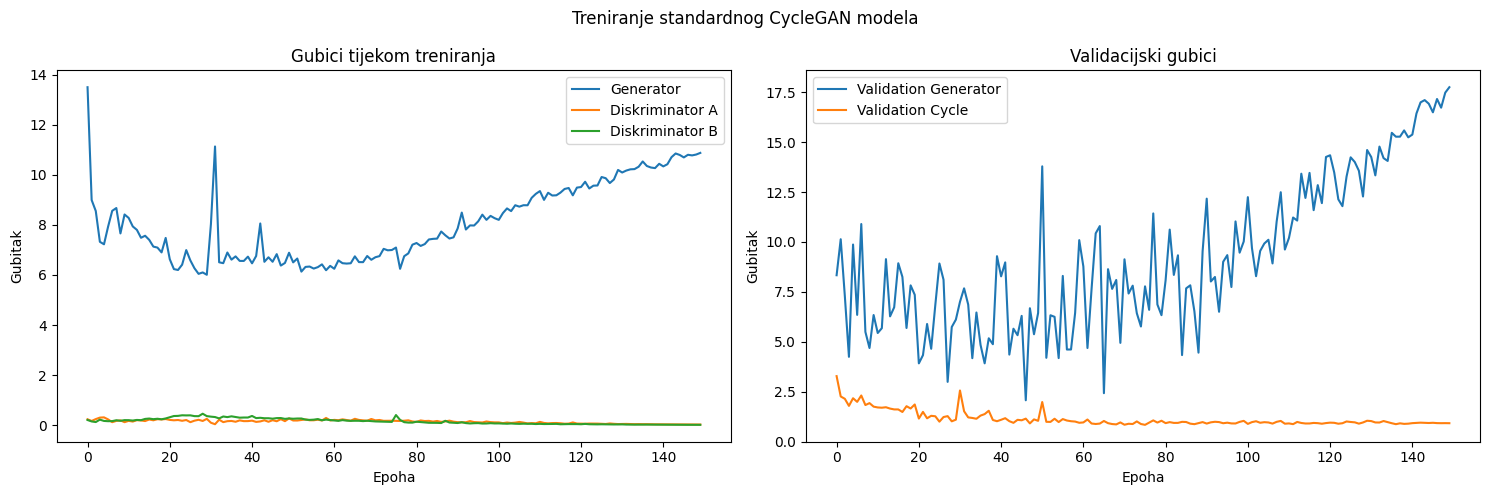

In [12]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [13]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.13it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8015
  MSE: 0.004279
  PSNR: 23.84 dB

T2 -> T1 translacija:
  SSIM: 0.8674
  MSE: 0.003229
  PSNR: 25.18 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8631
  MSE: 0.003229
  PSNR: 24.97 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8503
  MSE: 0.003257
  PSNR: 24.95 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6863
  MSE: 0.007064
  PSNR: 21.66 dB

T2 -> T1 translacija:
  SSIM: 0.7840
  MSE: 0.005333
  PSNR: 23.00 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.7709
  MSE: 0.005334
  PSNR: 22.79 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7526
  MSE: 0.005375
  PSNR: 22.78 dB


Vizualizacija rezultata na test setu:


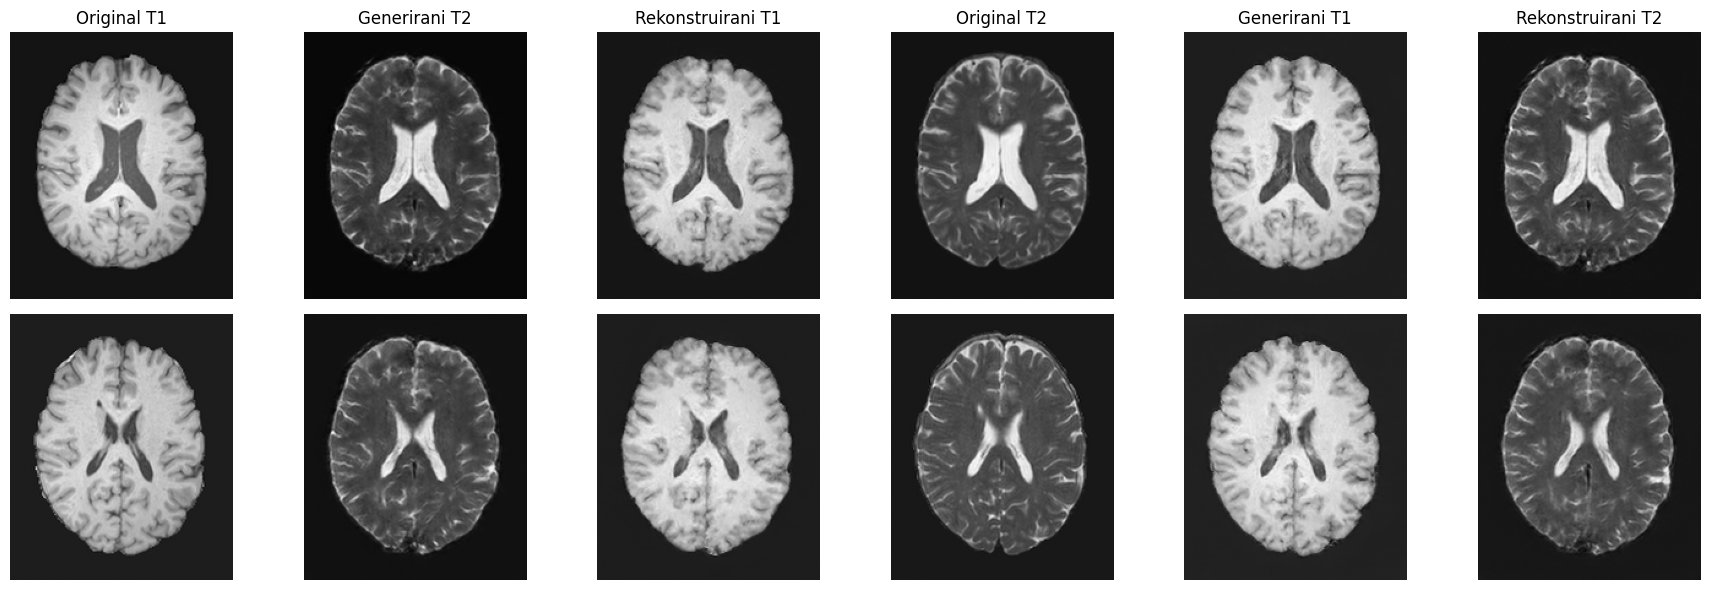

In [14]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=2, config=config)

In [15]:
best_G_AB_cycle = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [16]:
print("Testiranje najboljih modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.12it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8335
  MSE: 0.003492
  PSNR: 24.83 dB

T2 -> T1 translacija:
  SSIM: 0.8599
  MSE: 0.003547
  PSNR: 24.73 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8970
  MSE: 0.002433
  PSNR: 26.24 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8823
  MSE: 0.002511
  PSNR: 26.16 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7350
  MSE: 0.005768
  PSNR: 22.65 dB

T2 -> T1 translacija:
  SSIM: 0.7739
  MSE: 0.005858
  PSNR: 22.55 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8297
  MSE: 0.004018
  PSNR: 24.06 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8096
  MSE: 0.004148
  PSNR: 23.98 dB


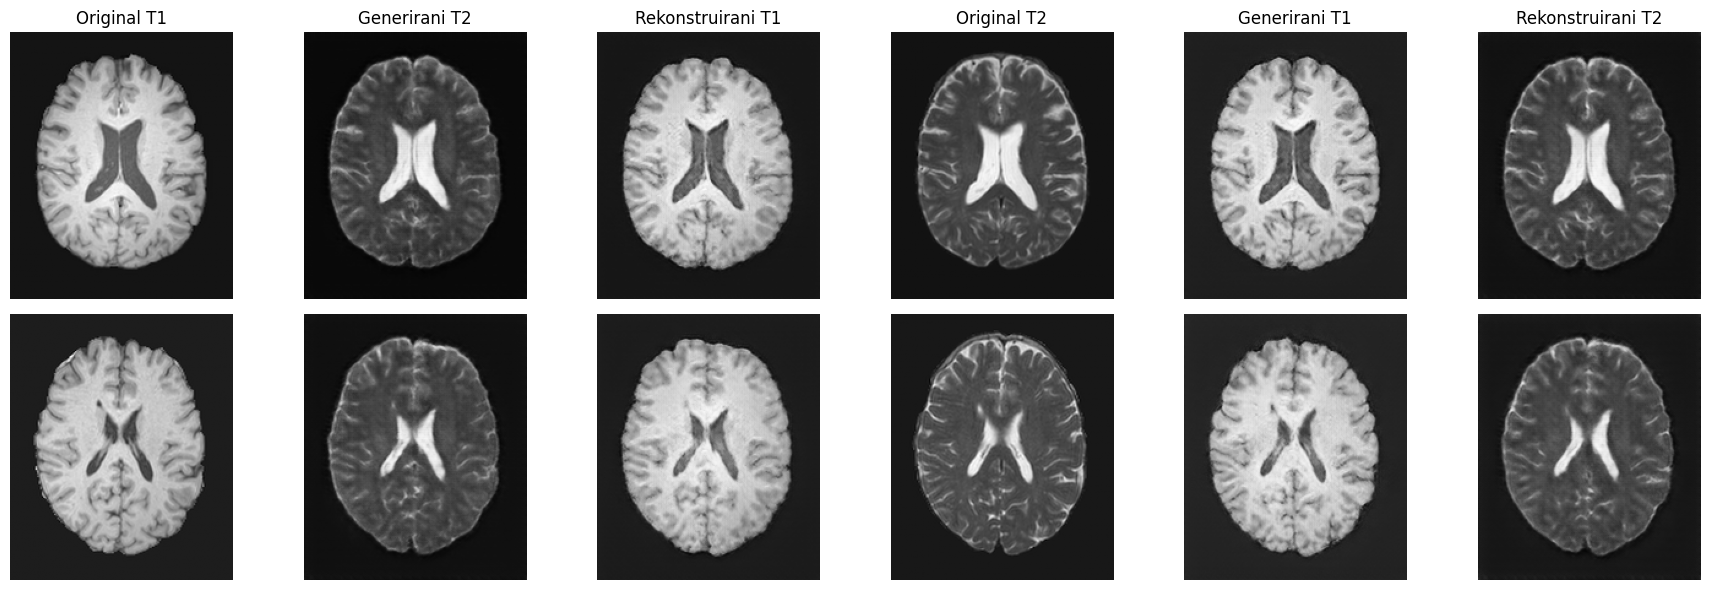

In [17]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=2, config=config
)

In [18]:
best_G_AB_gan = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [19]:
print("Testiranje najboljih modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.14it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7901
  MSE: 0.004922
  PSNR: 23.22 dB

T2 -> T1 translacija:
  SSIM: 0.8577
  MSE: 0.003678
  PSNR: 24.59 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8745
  MSE: 0.003360
  PSNR: 24.86 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8349
  MSE: 0.003886
  PSNR: 24.21 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6782
  MSE: 0.008131
  PSNR: 21.04 dB

T2 -> T1 translacija:
  SSIM: 0.7680
  MSE: 0.006075
  PSNR: 22.41 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.7918
  MSE: 0.005550
  PSNR: 22.69 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7418
  MSE: 0.006418
  PSNR: 22.03 dB


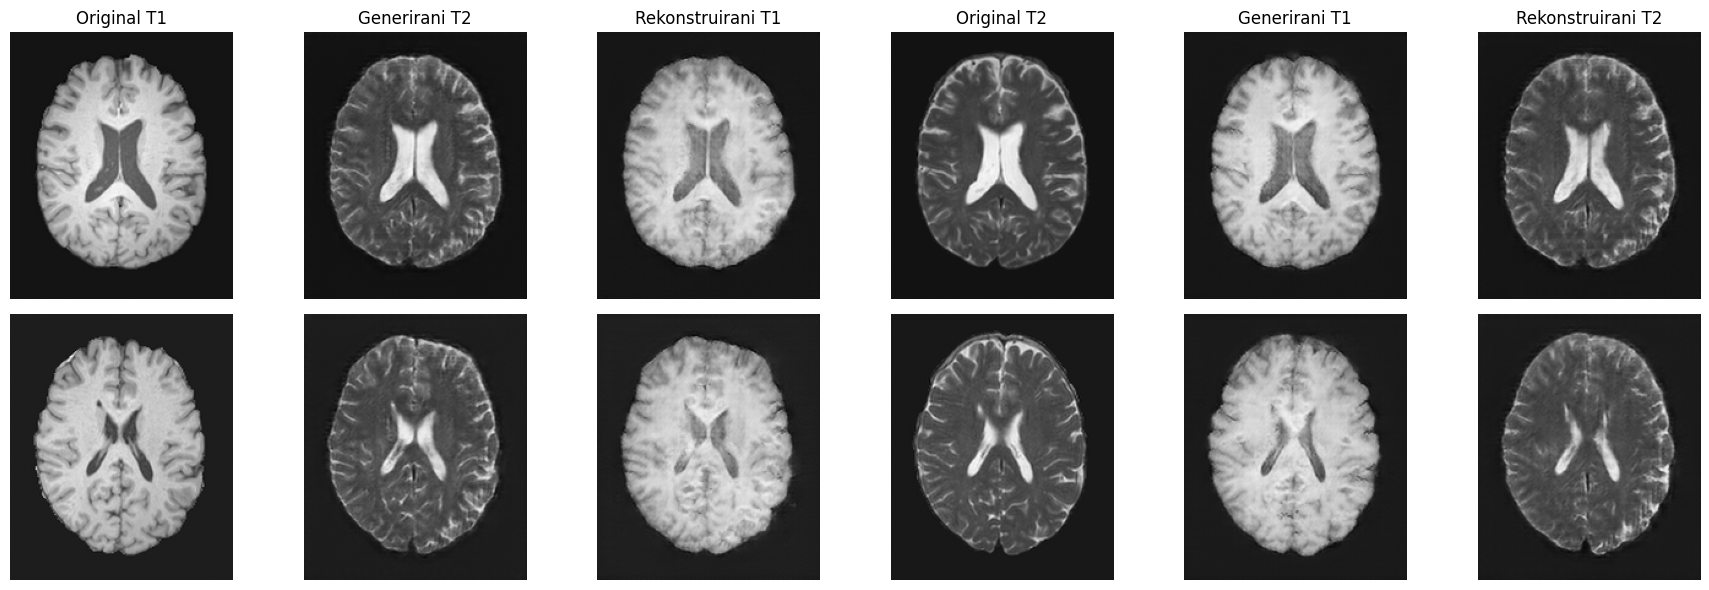

In [20]:
visualize_results(
    best_G_AB_gan, best_G_BA_gan, test_dataloader, num_samples=2, config=config
)